In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from numpy import array
import plotly.graph_objects as go

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import ParameterGrid
from pmdarima import model_selection
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# UTILS

# Перетворення ряду в стаціонарний за допомогою диференціювання
def make_stationary(series, diff_level=1):
    differenced_series = series.diff(diff_level).dropna()
    
    return differenced_series

# Розрахунок MA
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        if i < window_size - 1:
            moving_averages.append(np.nan)  # Додаємо NaN для перших window_size - 1 днів
        else:
            window = data[i - window_size + 1:i + 1]
            window_average = np.mean(window)
            moving_averages.append(window_average)
    return moving_averages

# Розрахунок RSI
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

# Перевірка даних на пропушенні значення
def checkMissVal(data):
  missing_values = data.isnull().sum()
  print("Counts of missing values:")
  print(missing_values) 

# Перевірка даних на стаціонарність за допмогою тесту Дікі Фулера
def adf_test(data, autolag='AIC', regression='ct'):
    adftest = adfuller(data, autolag=autolag, regression=regression)
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
  
# Перевірка даних на рівень дисперсії
def calculate_variance(data):
    standard_deviation = np.std(data)
    range_of_data = np.max(data) - np.min(data)
    
    return standard_deviation, range_of_data
  
# Описові статистики
def descriptive_statistics(column):
    stats = column.describe()
    
    print("Описові статистики для стовпчика:")
    print(stats)

# Розрахунок MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Створення графіку
def plot_line_chart(dataframe, title, yaxis_title, y_columns=None, x_column=None):
    fig = go.Figure()
    
    columns = y_columns if y_columns else dataframe.columns
    xaxis = dataframe[x_column] if x_column in dataframe.columns else dataframe.index

    for column in columns:
        fig.add_trace(go.Scatter(x=xaxis, y=dataframe[column], mode='lines', name=column))

    fig.update_layout(title=title, xaxis_title='Дата', yaxis_title=yaxis_title)

    fig.show()
    
def plot_rsi(rsi):
    # Створення графіку
    fig = go.Figure()

    # Додавання графіку RSI
    fig.add_trace(go.Scatter(x=rsi.index, y=rsi, mode='lines', name='RSI',  line=dict(color='orange', width=2.5)))

    # Горизонтальні лінії
    fig.add_shape(type="line", x0=rsi.index[0], y0=30, x1=rsi.index[-1], y1=30, line=dict(color="grey", width=1.5, dash="dash"), xref='x', yref='y')
    fig.add_shape(type="line", x0=rsi.index[0], y0=70, x1=rsi.index[-1], y1=70, line=dict(color="grey", width=1.5, dash="dash"), xref='x', yref='y')

    # Налаштування графіку
    fig.update_layout(title='RSI Analysis', xaxis=dict(title='Date'), yaxis=dict(title='RSI'))

    # Показ графіка
    fig.show()

In [4]:
btc_data = pd.read_csv('BTC-USD.csv', index_col='Date', parse_dates=True)
btc_data.index.freq = 'D' 

# Побудова моделі декомпозиції
decomposition = seasonal_decompose(btc_data['Close'], model='multiplicative')

# Отримання складових
trend_cycle = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

btc_data["seasonal_index"] = seasonal

In [5]:
btc_data["ma_20"] = moving_average(btc_data['Close'], 20)
btc_data['rsi_14'] = get_rsi(btc_data['Close'], 14)
btc_data = btc_data.dropna()
btc_data.reset_index(drop=True, inplace=True)
btc_data.tail()

C:\Users\User\AppData\Local\Temp\ipykernel_9676\1566745061.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ret[i] < 0:
C:\Users\User\AppData\Local\Temp\ipykernel_9676\1566745061.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up.append(ret[i])
C:\Users\User\AppData\Local\Temp\ipykernel_9676\1566745061.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down.append(ret[i])


,Open,High,Low,Close,Volume,seasonal_index,ma_20,rsi_14
383,63162.76172,64390.45703,62285.98047,62334.81641,2.593073e+10,1.001647,63386.664454,45.781929
384,62332.64063,62986.08594,60877.12891,61187.94141,2.608817e+10,1.003706,63270.423829,42.973872
385,61191.19922,63404.91406,60648.07422,63049.96094,2.545334e+10,0.999584,63230.743360,48.497139
386,63055.19141,63446.74219,60208.78125,60792.77734,2.780495e+10,0.998761,63020.660157,43.053404
387,60791.75781,61059.21094,60708.19531,61059.21094,2.696748e+10,0.996027,62827.288477,43.854532


In [6]:
plot_line_chart(btc_data[["Close", "ma_20"]], "BTC price", "$")
plot_rsi(btc_data['rsi_14'])

In [7]:
# Вибір цільової змінної (Y) та екзогенних змінних (X)
Y = btc_data['Close']
X = btc_data[['seasonal_index']]

In [8]:
# Перевірка даних
print(Y.head())
print(X.head())

0    28245.98828
1    27276.91016
2    27817.50000
3    27591.38477
4    27525.33984
Name: Close, dtype: float64
   seasonal_index
0        0.999584
1        0.998761
2        0.996027
3        0.998052
4        1.002223


In [9]:
# Перевірка на стаціонарність
adf_test(Y)


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.3257052458187553
P-Value: 0.4197871692219399
Number of lags: 14
Number of observations: 373
Critical Values: {'1%': -3.983247959051523, '5%': -3.422326330643594, '10%': -3.1340105459681302}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


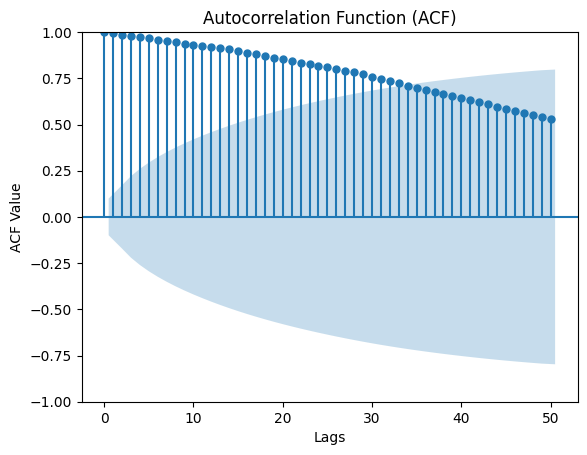

In [10]:
plot_acf(Y, lags=50)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

In [11]:
Y_diff = make_stationary(Y)

In [17]:
adf_test(Y_diff)

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.977268639580033
P-Value: 0.00947007152018883
Number of lags: 13
Number of observations: 373
Critical Values: {'1%': -3.983247959051523, '5%': -3.422326330643594, '10%': -3.1340105459681302}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


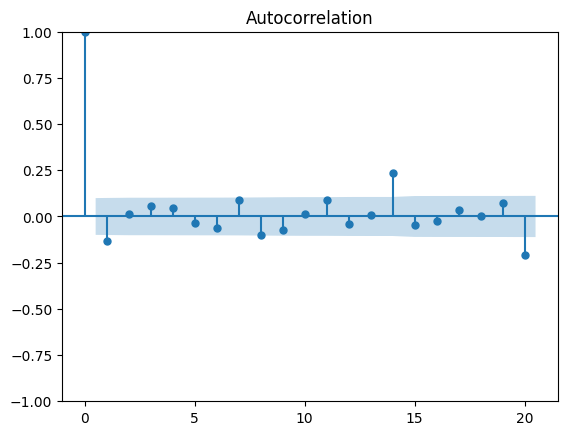

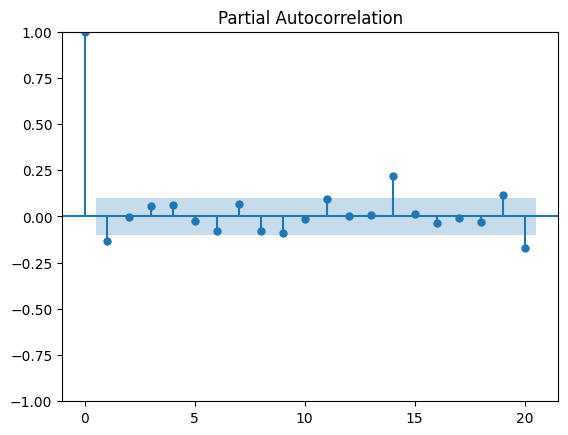

In [14]:
# Determine the order of ARIMA model (p, d, q)
# Plot ACF and PACF to determine the values of p and q
plot_acf(Y_diff, lags=20)
plot_pacf(Y_diff, lags=20)
plt.show()

In [15]:
# Створення та оцінка моделі
param_grid = {'p': [0, 1, 20],
              'd': [1],
              'q': [0, 1, 20],
              'P': [0, 14],
              'D': [0],
              'Q': [0]}

grid = ParameterGrid(param_grid)

In [16]:
#Parameter tuning -> start by creating an empty list to store the errors
rmse = []
#Parameter loop
for params in grid:
  #model
  print(params)
  model = pm.ARIMA(order = (params['p'],params['d'],params['q']),
                  seasonal_order = (params['P'],params['D'],params['Q'], 7),
                  suppress_warning = True,
                  force_stationarity = False)
  #CV
  cv = model_selection.RollingForecastCV(h = 6,
                                        step = 1,
                                        initial = Y.shape[0] - 24)
  cv_score = model_selection.cross_val_score(model,
                                            y = Y,
                                            scoring = 'mean_squared_error',
                                            cv = cv,
                                            verbose = 2,
                                            error_score = 1000000000000000)

  #Error
  error = np.sqrt(np.average(cv_score))
  rmse.append(error)

{'D': 0, 'P': 0, 'Q': 0, 'd': 1, 'p': 0, 'q': 0}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 ...............

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=1 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=2 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=14 .........................................................
[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'D': 0, 'P': 0, 'Q': 0, 'd': 1, 'p': 20, 'q': 0}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 ..............

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=1 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=2 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=12 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 0, 'q': 0}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 0, 'q': 1}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 0, 'q': 20}
[CV] fold=0 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=1 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=2 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=12 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 1, 'q': 0}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 1, 'q': 1}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=12 .........................................................
[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 1, 'q': 20}
[CV] fold=0 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=1 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=2 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=3 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=4 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=5 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=6 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=7 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=8 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=9 ..........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=10 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=11 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=12 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=13 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=14 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=15 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=16 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=17 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[CV] fold=18 .........................................................


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'D': 0, 'P': 14, 'Q': 0, 'd': 1, 'p': 20, 'q': 0}
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .............

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\model_selection\_validation.py:94: ModelFitWarning:

Estimator fit failed. The score on this train-test partition will be set to 1000000000000000.000000. Details: 
ValueError: Invalid model: autoregressive lag(s) {14, 7} are in both the seasonal and non-seasonal autoregressive components.


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\model_selection\_validation.py:94: ModelFitWarning:

Estimator fit failed. The score on this train-test partition will be set to 1000000000000000.000000. Details: 
ValueError: Invalid model: autoregressive lag(s) {14, 7} are in both the seasonal and non-seasonal autoregressive components.


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\model_selection\_validation.py:94: ModelFitWarning:

Estimator fit failed. The score on this train-test partition will be set to 1000000000000000.000000. Details: 
ValueErro

In [18]:
#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
print(best_params)

               14
D        0.000000
P       14.000000
Q        0.000000
d        1.000000
p        1.000000
q       20.000000
rmse  2418.630885


In [31]:
model = SARIMAX(endog=Y, order=(20, 1, 0))
results = model.fit(disp=False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  388
Model:              SARIMAX(20, 1, 0)   Log Likelihood               -3271.474
Date:                Mon, 20 May 2024   AIC                           6584.949
Time:                        16:53:46   BIC                           6668.076
Sample:                             0   HQIC                          6617.911
                                - 388                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1036      0.033     -3.150      0.002      -0.168      -0.039
ar.L2          0.0270      0.041      0.653      0.514      -0.054       0.108
ar.L3          0.0394      0.046      0.862      0.3

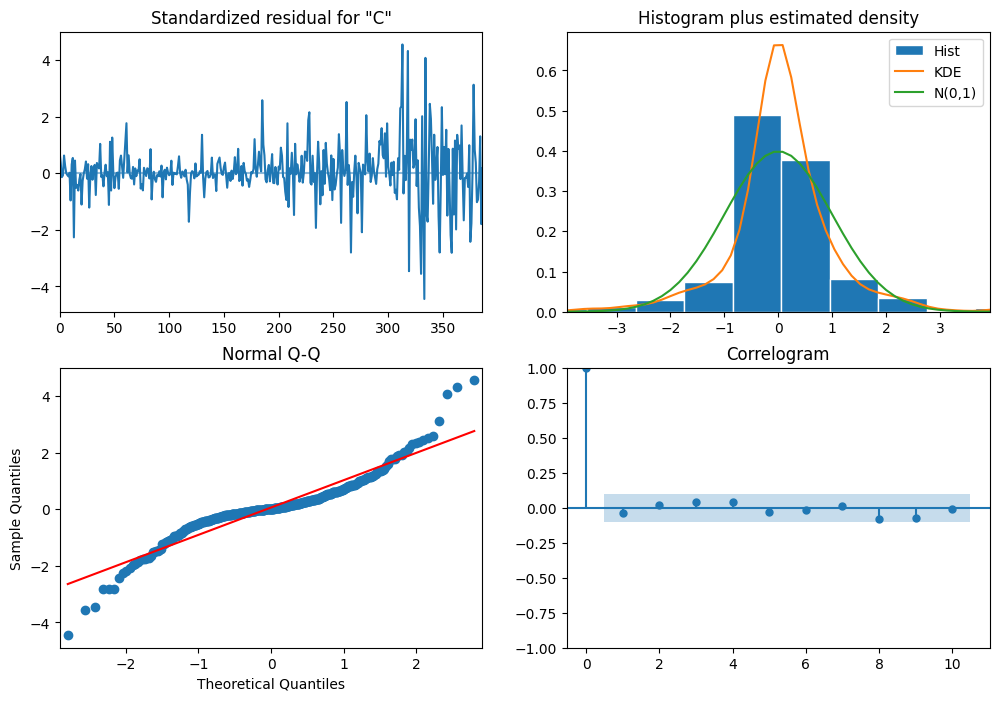

In [194]:

results.plot_diagnostics(figsize=(12, 8))
plt.show()


In [35]:
st_pred = results.get_prediction(start=1, dynamic=False) 
forecast_values = st_pred.predicted_mean
print(forecast_values)

mape = calculate_mape(btc_data["Close"], forecast_values)



# Create trace for original data
trace_original = go.Scatter(x=btc_data.index, y=btc_data["Close"], mode='lines', name='Original Data')

# Create trace for fitted values
trace_fitted = go.Scatter(x=btc_data.index, y=forecast_values, mode='lines', name='Forecast Values', line=dict(color='red'))

# Create layout
layout = go.Layout(title='Static forecasting', xaxis=dict(title='Date'), yaxis=dict(title='Value'), legend=dict(orientation='h'), showlegend=True)

# Create figure
fig = go.Figure(data=[trace_original, trace_fitted], layout=layout)

# Plot figure
fig.show()
print("MAPE:", mape)

1      26562.786244
2      27708.228965
3      28309.765295
4      28251.345771
5      27594.942104
           ...     
383    63402.378533
384    61862.070735
385    61673.020916
386    62924.093099
387    60723.272079
Name: predicted_mean, Length: 387, dtype: float64


MAPE: 1.7270057961696803


In [39]:
st_pred = results.get_prediction(start=382, dynamic=True) 
forecast_values = st_pred.predicted_mean

# Create trace for original data
trace_original = go.Scatter(x=btc_data.index, y=btc_data["Close"][382:], mode='lines', name='Original Data')

# Create trace for fitted values
trace_fitted = go.Scatter(x=btc_data.index, y=forecast_values, mode='lines', name='Forecast Values', line=dict(color='red'))

# Create layout
layout = go.Layout(title='Static forecasting', xaxis=dict(title='Date'), yaxis=dict(title='Value'), legend=dict(orientation='h'), showlegend=True)

# Create figure
fig = go.Figure(data=[trace_original, trace_fitted], layout=layout)

# Plot figure
fig.show()
print("MAPE:", calculate_mape(btc_data["Close"][382:], forecast_values))

MAPE: 3.753576110278018


In [42]:
x_forecast = btc_data["seasonal_index"][5:10].values.reshape(-1, 1)

pred_future = results.get_forecast(steps=5, exog=x_forecast)

print(f'Середнє прогнозне значення:\n\n{pred_future.predicted_mean}')
print(f'\nІнетрвали довіри:\n\n{pred_future.conf_int()}')

Середнє прогнозне значення:

388    60415.941191
389    60176.079510
390    59832.909195
391    59427.070218
392    60146.753708
Name: predicted_mean, dtype: float64

Інетрвали довіри:

      lower Close   upper Close
388  58203.391393  62628.490990
389  57204.749604  63147.409416
390  56213.492172  63452.326218
391  55222.780592  63631.359843
392  55393.618596  64899.888820


In [41]:
fig = go.Figure()

# Додавання лінії прогнозованих середніх значень
fig.add_trace(go.Scatter(x=pred_future.predicted_mean.index,
                         y=pred_future.predicted_mean.values,
                         mode='lines',
                         name='Середні прогнозовані значення'))

# Заповнення діапазону між довірчими інтервалами
fig.add_trace(go.Scatter(x=pred_future.conf_int().index,
                         y=pred_future.conf_int().iloc[:, 0].values,
                         mode='lines',
                         line=dict(width=0),
                         showlegend=False))

fig.add_trace(go.Scatter(x=pred_future.conf_int().index,
                         y=pred_future.conf_int().iloc[:, 1].values,
                         mode='lines',
                         fill='tonexty',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(width=0),
                         name='Довірчий інтервал'))

# Налаштування макету та легенди
fig.update_layout(title='Прогнозовані значення з довірчим інтервалом',
                  xaxis_title='Дата',
                  yaxis_title='Значення',
                  legend=dict(x=0, y=1),
                  template='plotly_white')

fig.show()